<!--NAVIGATION-->
< [In-Depth: Support Vector Machines](05.07-Support-Vector-Machines.ipynb) | [Contents](Index.ipynb) | [In Depth: Principal Component Analysis](05.09-Principal-Component-Analysis.ipynb) >

<a href="https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.08-Random-Forests.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


# In-Depth: Decision Trees and Random Forests

# 深入：决策树和随机森林

> Previously we have looked in depth at a simple generative classifier (naive Bayes; see [In Depth: Naive Bayes Classification](05.05-Naive-Bayes.ipynb)) and a powerful discriminative classifier (support vector machines; see [In-Depth: Support Vector Machines](05.07-Support-Vector-Machines.ipynb)).
Here we'll take a look at motivating another powerful algorithm—a non-parametric algorithm called *random forests*.
Random forests are an example of an *ensemble* method, meaning that it relies on aggregating the results of an ensemble of simpler estimators.
The somewhat surprising result with such ensemble methods is that the sum can be greater than the parts: that is, a majority vote among a number of estimators can end up being better than any of the individual estimators doing the voting!
We will see examples of this in the following sections.
We begin with the standard imports:

前面我们深入的介绍了简单的生成分类器（朴素贝叶斯，参见[深入：朴素贝叶斯分类](05.05-Naive-Bayes.ipynb)）和强大的决定分类器（支持向量机，参见[深入：支持向量机](05.07-Support-Vector-Machines.ipynb)）。下面我来看另外一种强大的算法，一个没有参数被称为*随机森林*的算法。随机森林是一个集成的方法，这意味着它是建立在一系列简单评估器的组合基础上的。令人惊奇的是，这种方法的组合会比独立的算法应用要强大：即通过多个评估器得到的选举多数票结果要由于其中任何一个独立的评估器得到的结果。我们会在本节后面看到一些例子。首先还是进行需要的包导入：

In [17]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## Motivating Random Forests: Decision Trees

## 开始学习随机森林：决策树

> Random forests are an example of an *ensemble learner* built on decision trees.
For this reason we'll start by discussing decision trees themselves.

随机森林是构建在决策树基础上的*组合学习*的一种方法。因此我们先讨论一下决策树本身。

> Decision trees are extremely intuitive ways to classify or label objects: you simply ask a series of questions designed to zero-in on the classification.
For example, if you wanted to build a decision tree to classify an animal you come across while on a hike, you might construct the one shown here:

决策树是用来分类或者标记对象的非常直观的方法：你只需要简单的提出一系列设计好的问题，最终达到分类标签即可。例如，如果希望构建一个用来分类动物的决策树，你可以构建下面的这棵树：

![](figures/05.08-decision-tree.png)
[附录中生成图像的代码](06.00-Figure-Code.ipynb#Decision-Tree-Example)

> The binary splitting makes this extremely efficient: in a well-constructed tree, each question will cut the number of options by approximately half, very quickly narrowing the options even among a large number of classes.
The trick, of course, comes in deciding which questions to ask at each step.
In machine learning implementations of decision trees, the questions generally take the form of axis-aligned splits in the data: that is, each node in the tree splits the data into two groups using a cutoff value within one of the features.
Let's now look at an example of this.

这种二元的区分方式使得算法非常高效：在一个构造良好的树中，每个问题都会使得剩下的可用选项减半，这甚至在分类数量很多情况下也能迅速的得到结果。当然这个效率取决于每一步设计问题的技巧。在决策树的机器学习实现中，树中的问题通常都采用沿着轴来分割数据：也就是说，树中的每个节点会在数据的一个特征上应用一个阈值来将数据一分为二。下面我们看一个例子。

### Creating a decision tree

### 创建决策树

> Consider the following two-dimensional data, which has one of four class labels:

考虑下面的二维数据，具有四个分类标签：

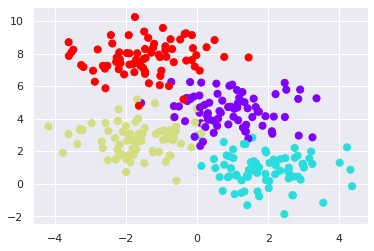

In [16]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

> A simple decision tree built on this data will iteratively split the data along one or the other axis according to some quantitative criterion, and at each level assign the label of the new region according to a majority vote of points within it.
This figure presents a visualization of the first four levels of a decision tree classifier for this data:

在这个数据上建立的简单决策树会沿着两个轴来分类数据，每一层的划分都会按照区域中大多数数据点的分类标签（多数票）来确定区域的标签值。下面的图像展示了头四层的决策树进行分类的可视化过程：

![](figures/05.08-decision-tree-levels.png)
[附录中生成图像的代码](06.00-Figure-Code.ipynb#Decision-Tree-Levels)

> Notice that after the first split, every point in the upper branch remains unchanged, so there is no need to further subdivide this branch.
Except for nodes that contain all of one color, at each level *every* region is again split along one of the two features.

上图看到第一层分类后，图中上部的分支一直保持不变，因此没有必要再对这个分支进行细分了。除非某个节点已经达到包含同一颜色的目的，否则每一层的不同区域都是再次沿着两个特征其中之一对数据进行再次细分。

> This process of fitting a decision tree to our data can be done in Scikit-Learn with the ``DecisionTreeClassifier`` estimator:

这个决策树的拟合过程可以通过Scikit-Learn中的`DecisionTreeClassifier`评估器来实现：

In [3]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)

> Let's write a quick utility function to help us visualize the output of the classifier:

然后我们写一个工具函数帮助我们展示分类器的数据可视化：

In [4]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # 绘制训练集数据点
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # 模型拟合
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # 填充结果区域
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

> Now we can examine what the decision tree classification looks like:

下面我们可以看一下决策树分类器的分类效果了：

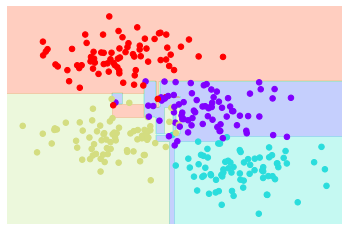

In [5]:
visualize_classifier(DecisionTreeClassifier(), X, y)

> If you're running this notebook live, you can use the helpers script included in [The Online Appendix](06.00-Figure-Code.ipynb#Helper-Code) to bring up an interactive visualization of the decision tree building process:

如果你在使用交互式的notebook的话，你可以使用使用一个工具脚本[附录中工具脚本](06.00-Figure-Code.ipynb#Helper-Code)来展示决策树动态可视化构建过程：

In [6]:
# helpers_05_08可在附录中找到
import helpers_05_08
helpers_05_08.plot_tree_interactive(X, y);

interactive(children=(Dropdown(description='depth', index=1, options=(1, 5), value=5), Output()), _dom_classes…

> Notice that as the depth increases, we tend to get very strangely shaped classification regions; for example, at a depth of five, there is a tall and skinny purple region between the yellow and blue regions.
It's clear that this is less a result of the true, intrinsic data distribution, and more a result of the particular sampling or noise properties of the data.
That is, this decision tree, even at only five levels deep, is clearly over-fitting our data.

随着深度（树节点层次）增加，我们会得到一个非常奇怪的分类区域形状；如上面深度为5时，图像下部会出现一条很高的狭长紫色区域，处于绿色和蓝色区域之间。从直觉上我们就可以认为这是错误的，这个结果不是来源自数据的内在分布特性，而更像是通过数据中个别的样本或噪音获得的。也就是说决策树即使只有5层深度也发生了数据的过拟合。

### Decision trees and over-fitting

### 决策树和过拟合

> Such over-fitting turns out to be a general property of decision trees: it is very easy to go too deep in the tree, and thus to fit details of the particular data rather than the overall properties of the distributions they are drawn from.
Another way to see this over-fitting is to look at models trained on different subsets of the data—for example, in this figure we train two different trees, each on half of the original data:

这种过拟合是决策树经常出现的问题：很可能就构建了一个深度太大的决策树，这样的树会聚焦在数据的特定数据点或噪音之上，而不是数据本身的分布特性之上。另外一种看出过拟合的方法是在数据不同子集上的训练结果，例如，下面两张图表示的是在数据集各一半的数据电商训练得到的两个不同的模型：

![](figures/05.08-decision-tree-overfitting.png)
[附录中生成图像的代码](06.00-Figure-Code.ipynb#Decision-Tree-Overfitting)

> It is clear that in some places, the two trees produce consistent results (e.g., in the four corners), while in other places, the two trees give very different classifications (e.g., in the regions between any two clusters).
The key observation is that the inconsistencies tend to happen where the classification is less certain, and thus by using information from *both* of these trees, we might come up with a better result!

很明显在一些位置上，两棵树都产生了相同的结果（例如四个角附近的位置），但是在其他位置上，两个模型给出了非常差异的分类结果（例如在两个分类的交界处）。这里的关键是这些差异一般会出现在分类器确定性较低的位置，因此如果我们同时使用这两棵树的特性的话，可以得到更好的结果。

> If you are running this notebook live, the following function will allow you to interactively display the fits of trees trained on a random subset of the data:

如果使用notebooke交互模式，下面的函数能动态展示使用数据的随机子集训练得到的模型：

In [18]:
# helpers_05_08代码能在附录中找到
import helpers_05_08
helpers_05_08.randomized_tree_interactive(X, y)

interactive(children=(Dropdown(description='random_state', options=(0, 100), value=0), Output()), _dom_classes…

> Just as using information from two trees improves our results, we might expect that using information from many trees would improve our results even further.

正如使用两棵树的信息能改善结果，我们可以认为如果使用更多的树的信息能够更好的改善结果。

## Ensembles of Estimators: Random Forests

## 评估器合成：随机森林

> This notion—that multiple overfitting estimators can be combined to reduce the effect of this overfitting—is what underlies an ensemble method called *bagging*.
Bagging makes use of an ensemble (a grab bag, perhaps) of parallel estimators, each of which over-fits the data, and averages the results to find a better classification.
An ensemble of randomized decision trees is known as a *random forest*.

前面的术语，即多个过拟合的评估器可以被合并来减少过拟合的方法，被称为*装袋*，是一种团体学习的算法。装袋将一些并行的评估器组装（类似塞到袋子里）起来，其中的每个评估器都会产生过拟合，然后对结果求平均来得到一个更好的分类。对随机决策树的组装被称为*随机森林*。

> This type of bagging classification can be done manually using Scikit-Learn's ``BaggingClassifier`` meta-estimator, as shown here:

这种类型的装袋分类可以通过Scikit-Learn的`BagginClassifier`元评估器来手动实现，如下例：

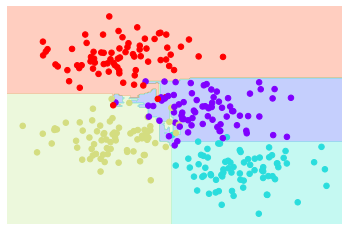

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8,
                        random_state=1)

bag.fit(X, y)
visualize_classifier(bag, X, y)

> In this example, we have randomized the data by fitting each estimator with a random subset of 80% of the training points.
In practice, decision trees are more effectively randomized by injecting some stochasticity in how the splits are chosen: this way all the data contributes to the fit each time, but the results of the fit still have the desired randomness.
For example, when determining which feature to split on, the randomized tree might select from among the top several features.
You can read more technical details about these randomization strategies in the [Scikit-Learn documentation](http://scikit-learn.org/stable/modules/ensemble.html#forest) and references within.

在上例中，我们通过在数据集的随机80%的数据点上拟合出100个模型。在实践中，决策树可以通过注入更多的随机性来选择子数据集以达到更好的效果：这个方法中所有的数据在每次拟合过程中都会产生贡献，但是拟合的结果仍然具有期望的随机性。例如当决定哪个特征来划分数据集时，随机决策树可以从前面几个特征中进行不同的选择。你可以在[Scikit-Learn在线文档](http://scikit-learn.org/stable/modules/ensemble.html#forest)中督导更多这些随机策略的技术细节。

> In Scikit-Learn, such an optimized ensemble of randomized decision trees is implemented in the ``RandomForestClassifier`` estimator, which takes care of all the randomization automatically.
All you need to do is select a number of estimators, and it will very quickly (in parallel, if desired) fit the ensemble of trees:

在Scikit-Learn中，上述的随机决策树的优化组合算法被实现在`RandomForestClassifier`评估器中，它能全自动地处理所有的随机情况。你只需要设置评估器的个数，它能迅速的（如果需要的话会进行并行计算）拟合整个森林：

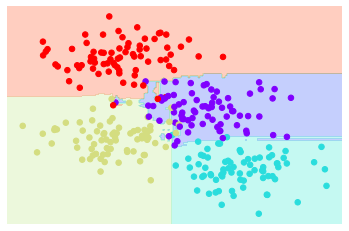

In [20]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y);

> We see that by averaging over 100 randomly perturbed models, we end up with an overall model that is much closer to our intuition about how the parameter space should be split.

上面例子可以看到，通过在100个随机选择的模型上进行平均，我们能够得到一个更加复合我们对数据集分布的直觉模型。

## Random Forest Regression

## 随机森林回归

> In the previous section we considered random forests within the context of classification.
Random forests can also be made to work in the case of regression (that is, continuous rather than categorical variables). The estimator to use for this is the ``RandomForestRegressor``, and the syntax is very similar to what we saw earlier.

在前面内容中我们介绍了随机森林应用在分类场景下的方法。随机森林也能在回归场景中使用（也就是说不是处理离散的分类而是处理连续的分类）。实现这个场景的评估器是`RandomForestRegressor`，它的语法和前面看到的分类语法很相似。

> Consider the following data, drawn from the combination of a fast and slow oscillation:

考虑下面由一个快速震荡和缓慢震荡组合得到的数据集：

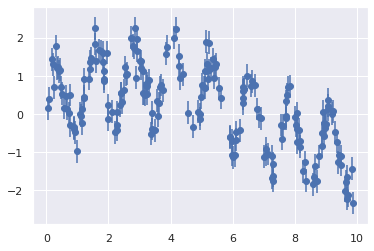

In [21]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x, y, 0.3, fmt='o');

> Using the random forest regressor, we can find the best fit curve as follows:

使用随机森林回归，我们能获得下面的最佳拟合曲线：

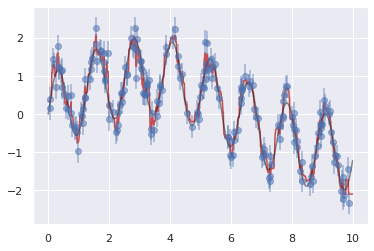

In [22]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(200)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

> Here the true model is shown in the smooth gray curve, while the random forest model is shown by the jagged red curve.
As you can see, the non-parametric random forest model is flexible enough to fit the multi-period data, without us needing to specifying a multi-period model!

上面真实的数据使用灰色光滑的曲线展示，而随机森林模型使用红色锯齿曲线展示。可以看到无参数的随机森林模型可以足够灵活的拟合多周期数据，甚至不需要指定任何多周期模型。

## Example: Random Forest for Classifying Digits

## 例子：使用随机森林分类手写数字

> Earlier we took a quick look at the hand-written digits data (see [Introducing Scikit-Learn](05.02-Introducing-Scikit-Learn.ipynb)).
Let's use that again here to see how the random forest classifier can be used in this context.

前面我们快速的浏览了一下手写数字数据（参见[Scikit-Learn简介](05.02-Introducing-Scikit-Learn.ipynb)）。下面我们来看看随机森林分类器在这个场景下的应用。

In [23]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

> To remind us what we're looking at, we'll visualize the first few data points:

展示前面若干数据点，方便我们理解面对的数据集情况：

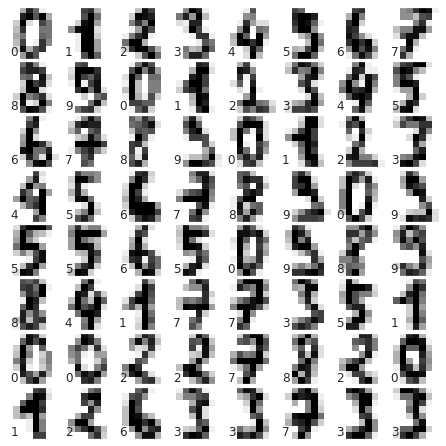

In [24]:
# 设置图表
fig = plt.figure(figsize=(6, 6))  # 图表尺寸
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# 绘制数字，每个数字都是8x8大小
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    
    # 添加数字的标签
    ax.text(0, 7, str(digits.target[i]))

> We can quickly classify the digits using a random forest as follows:

然后我们很快就能使用随机森林来分类这些数字：

In [26]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target,
                                                random_state=0)
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

> We can take a look at the classification report for this classifier:

然后看一下这个分类器的分类性能报告：

In [27]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       1.00      0.96      0.98        45
           2       0.95      1.00      0.98        42
           3       0.98      0.98      0.98        45
           4       0.97      1.00      0.99        37
           5       0.98      0.98      0.98        48
           6       1.00      1.00      1.00        52
           7       1.00      0.96      0.98        50
           8       0.94      0.98      0.96        46
           9       0.98      0.98      0.98        47

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



> And for good measure, plot the confusion matrix:

为了更清晰，可以绘制混淆矩阵：

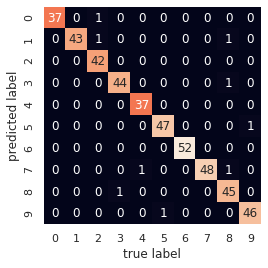

In [28]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

> We find that a simple, untuned random forest results in a very accurate classification of the digits data.

从这个例子我们发现，一个这么简单未经过优化的随机森林就能在手写数字分类上得到非常精确的分类结果。

## Summary of Random Forests

## 随机森林总结

> This section contained a brief introduction to the concept of *ensemble estimators*, and in particular the random forest – an ensemble of randomized decision trees.
Random forests are a powerful method with several advantages:

> - Both training and prediction are very fast, because of the simplicity of the underlying decision trees. In addition, both tasks can be straightforwardly parallelized, because the individual trees are entirely independent entities.
- The multiple trees allow for a probabilistic classification: a majority vote among estimators gives an estimate of the probability (accessed in Scikit-Learn with the ``predict_proba()`` method).
- The nonparametric model is extremely flexible, and can thus perform well on tasks that are under-fit by other estimators.

本节中介绍了*组合评估器*的概念，进一步介绍了随机森林，一个随机化决策树的团队算法。随机森林由于下述优点使其成为很强大的一个方法：

- 训练和预测都非常快，因为其基础决策树计算非常简单。并且所有的任务都能直接地并行化，因为每一棵独立的树都是完全无关的。
- 多棵决策树都可以进行概率分类：区域内的大多数票给出了概率分布的估计值（使用Scikit-Learn的`predict_proba()`实现）。
- 无参数的模型非常灵活，可以在其他评估器欠拟合的情况下工作得很良好。

> A primary disadvantage of random forests is that the results are not easily interpretable: that is, if you would like to draw conclusions about the *meaning* of the classification model, random forests may not be the best choice.

随机森林最主要的缺点在于结果不容易解释：也即是说，如果你试图从分类模型中提取深层次的*含义*的话，随机森林可能不是最好的选择。

<!--NAVIGATION-->
< [In-Depth: Support Vector Machines](05.07-Support-Vector-Machines.ipynb) | [Contents](Index.ipynb) | [In Depth: Principal Component Analysis](05.09-Principal-Component-Analysis.ipynb) >

<a href="https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.08-Random-Forests.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>
